# Step 1: Imports + Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib

df = pd.read_csv("air_quality_dataset.csv")
df.head()

,SITE_ID,Week,Year,DATEOFF,Ca,Cl,HNO3,HNO3 PPB,K,Mg,Na,NH4,NO3,SO2,SO2 PPB,SO4,TNO3,DATEON
0,ABT147,27,2023,7/11/2023 8:00:00 AM,0.042,0.032,0.759,0.295,0.129,0.022,0.055,0.279,0.088,0.258,0.098,0.915,0.834,7/04/2023
1,ABT147,28,2023,7/18/2023 8:00:00 AM,0.114,0.033,0.74,0.287,0.091,0.056,0.302,0.268,0.332,0.316,0.121,1.273,1.06,7/11/2023
2,ABT147,29,2023,7/25/2023 8:00:00 AM,0.062,0.033,0.648,0.251,0.074,0.02,0.07,0.276,0.128,0.294,0.112,0.705,0.766,7/18/2023
3,ABT147,30,2023,8/01/2023 8:00:00 AM,0.064,0.033,0.598,0.232,0.069,0.022,0.096,0.304,0.196,0.333,0.127,0.841,0.784,7/25/2023
4,ABT147,31,2023,8/08/2023 8:00:00 AM,0.059,0.176,0.348,0.135,0.065,0.033,0.208,0.366,0.382,0.331,0.126,0.596,0.724,8/01/2023


# Step 2: Quick inspection

In [2]:
print(df.shape)
print(df.columns.tolist())
df.info()
print(df.isna().sum().sort_values(ascending=False).head(20))

(2103, 18)
['SITE_ID', 'Week', 'Year', 'DATEOFF', 'Ca', 'Cl', 'HNO3', 'HNO3 PPB', 'K', 'Mg', 'Na', 'NH4', 'NO3', 'SO2', 'SO2 PPB', 'SO4', 'TNO3', 'DATEON']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2103 entries, 0 to 2102
Data columns (total 18 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   SITE_ID   2103 non-null   object
 1   Week      2103 non-null   int64 
 2   Year      2103 non-null   int64 
 3   DATEOFF   2103 non-null   object
 4   Ca        2103 non-null   object
 5   Cl        2103 non-null   object
 6   HNO3      2103 non-null   object
 7   HNO3 PPB  2103 non-null   object
 8   K         2103 non-null   object
 9   Mg        2103 non-null   object
 10  Na        2103 non-null   object
 11  NH4       2103 non-null   object
 12  NO3       2103 non-null   object
 13  SO2       2103 non-null   object
 14  SO2 PPB   2103 non-null   object
 15  SO4       2103 non-null   object
 16  TNO3      2103 non-null   object
 17  DATEON    

# Step 3: Convert numeric columns + parse dates

In [3]:
numeric_cols = ['Ca','Cl','HNO3','HNO3 PPB','K','Mg','Na','NH4','NO3','SO2','SO2 PPB','SO4','TNO3']
for c in numeric_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

if 'DATEOFF' in df.columns:
    df['DATEOFF'] = pd.to_datetime(df['DATEOFF'], errors='coerce')
if 'DATEON' in df.columns:
    df['DATEON'] = pd.to_datetime(df['DATEON'], errors='coerce')

# Step 4: Feature engineering from datetime

In [4]:
if 'DATEOFF' in df.columns:
    df['year']  = df['DATEOFF'].dt.year
    df['month'] = df['DATEOFF'].dt.month
    df['day']   = df['DATEOFF'].dt.day
    df['weekday'] = df['DATEOFF'].dt.weekday
    df['weekofyear'] = df['DATEOFF'].dt.isocalendar().week.astype(int)

# Step 5: Define target and drop missing

In [5]:
target = 'SO2'
df = df.dropna(subset=[target])

# Step 6: Choose features (numeric vs categorical)

In [6]:
exclude = [target, 'DATEOFF', 'DATEON']
features = [c for c in df.columns if c not in exclude]
numeric_features = [c for c in features if c in numeric_cols or df[c].dtype in [np.float64, np.int64]]
numeric_features = [c for c in numeric_features if c != target]
categorical_features = [c for c in features if c not in numeric_features]
print('Numeric features:', numeric_features)
print('Categorical features:', categorical_features)

Numeric features: ['Week', 'Year', 'Ca', 'Cl', 'HNO3', 'HNO3 PPB', 'K', 'Mg', 'Na', 'NH4', 'NO3', 'SO2 PPB', 'SO4', 'TNO3', 'weekofyear']
Categorical features: ['SITE_ID', 'year', 'month', 'day', 'weekday']


# Step 7: Preprocessing (imputer + scaler + one-hot)

In [9]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])


# Step 8: Train/Test Split

In [10]:
X = df[numeric_features + categorical_features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 9: Build Model Pipelines

In [11]:
pipe_lr = Pipeline(steps=[('preprocessor', preprocessor),
                         ('regressor', LinearRegression())])

pipe_rf = Pipeline(steps=[('preprocessor', preprocessor),
                         ('regressor', RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1))])

pipe_lr.fit(X_train, y_train)
pipe_rf.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


# Step 10: Evaluate Models

LinearRegression RMSE: 0.0008, R2: 1.0000


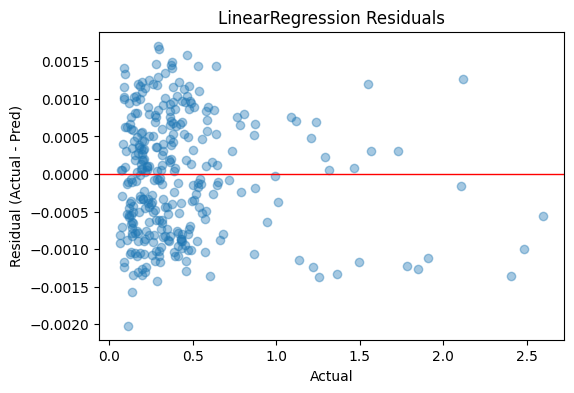

RandomForest RMSE: 0.0138, R2: 0.9988


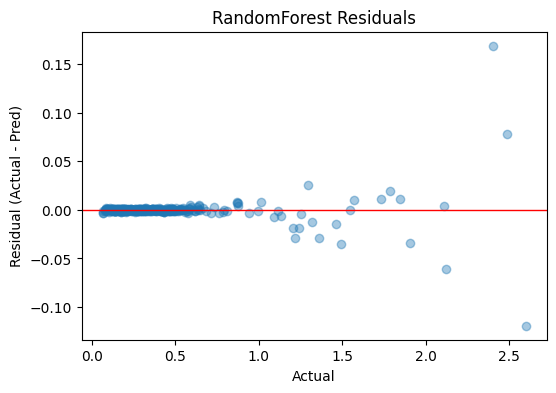

In [12]:
def evaluate(model, X_test, y_test, name="model"):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"{name} RMSE: {rmse:.4f}, R2: {r2:.4f}")
    plt.figure(figsize=(6,4))
    plt.scatter(y_test, y_test - y_pred, alpha=0.4)
    plt.axhline(0, color='red', linewidth=1)
    plt.xlabel("Actual")
    plt.ylabel("Residual (Actual - Pred)")
    plt.title(f"{name} Residuals")
    plt.show()
    return y_pred

y_pred_lr = evaluate(pipe_lr, X_test, y_test, "LinearRegression")
y_pred_rf = evaluate(pipe_rf, X_test, y_test, "RandomForest")

# Step 11: Save Trained Model

In [13]:
joblib.dump(pipe_rf, "so2_pipeline_rf.joblib")

['so2_pipeline_rf.joblib']